<h2 style="color:blue" align="center">Quantization Tutorial</h2>

Quantization is a technique to downsize a trained model so that you can deploy it on EDGE devices. In this tutorial we will,

(1) Train a hand written digits model

(2) Export to a disk and check the size of that model

(3) Use two techniques for quantization (1) post training quantization (3) quantization aware training

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
(X_train, y_train) , (X_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
len(X_train)

60000

In [4]:
len(X_test)

10000

In [5]:
X_train[0].shape

(28, 28)

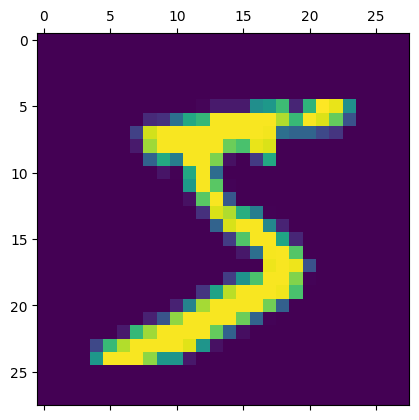

In [6]:
plt.matshow(X_train[0])

In [7]:
y_train[0]

5

In [8]:
X_train = X_train / 255
X_test = X_test / 255

In [9]:
X_train_flattened = X_train.reshape(len(X_train), 28*28)
X_test_flattened = X_test.reshape(len(X_test), 28*28)

In [10]:
X_train_flattened.shape

(60000, 784)

<h3 style='color:purple'>Using Flatten layer so that we don't have to call .reshape on input dataset</h3>

In [11]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2808 - accuracy: 0.9214
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1263 - accuracy: 0.9627
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0885 - accuracy: 0.9739
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0678 - accuracy: 0.9796
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0538 - accuracy: 0.9831


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.get_weights()[0]

array([[ 0.03551323,  0.07205738, -0.00551635, ..., -0.00673267,
         0.07582687,  0.05140695],
       [-0.00253781,  0.00380775, -0.06281307, ..., -0.00389622,
        -0.06231561,  0.00699098],
       [ 0.01974262, -0.0502142 , -0.0587194 , ...,  0.03821955,
         0.05993047,  0.06951742],
       ...,
       [-0.00325365,  0.04189916,  0.05681551, ...,  0.01053508,
        -0.05365919,  0.00018546],
       [ 0.07825789, -0.05191392, -0.04977319, ..., -0.07328358,
         0.04017652, -0.01779457],
       [-0.07287844, -0.00841371,  0.07772815, ..., -0.02686696,
         0.07986695,  0.01971756]], dtype=float32)

In [14]:
print(model.get_weights()[0].dtype)

float32


In [15]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 1ms/step - loss: 0.0820 - accuracy: 0.9751


[0.08198968321084976, 0.9750999808311462]

In [16]:
model.save("model.h5")

In [17]:
model.save("./saved_model/")

INFO:tensorflow:Assets written to: ./saved_model/assets


<h3 style='color:blue'>(1) Post training quantization</h3>

**Without quantization**

In [18]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
# converter
tflite_model = converter.convert()
# tflite_model

In [19]:

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()


input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:")
print(input_details)

print("\nOutput details:")
print(output_details)


# # Define a function to get layer outputs
# def get_layer_output(interpreter, layer_index, input_data):
#     interpreter.set_tensor(input_details[0]['index'], input_data)
#     interpreter.invoke()
#     layer_output = interpreter.get_tensor(output_details[layer_index]['index'])
#     return layer_output


Input details:
[{'name': 'serving_default_flatten_input:0', 'index': 0, 'shape': array([ 1, 28, 28]), 'shape_signature': array([-1, 28, 28]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]

Output details:
[{'name': 'StatefulPartitionedCall:0', 'index': 9, 'shape': array([ 1, 10]), 'shape_signature': array([-1, 10]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


**With quantization**

In [20]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [21]:
import tensorflow as tf


interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:")
print(input_details)

print("\nOutput details:")
print(output_details)

# print("\nModel Summary:")
# print(interpreter)



# # Define a function to get layer outputs
# def get_layer_output(interpreter, layer_index, input_data):
#     interpreter.set_tensor(input_details[0]['index'], input_data)
#     interpreter.invoke()
#     layer_output = interpreter.get_tensor(output_details[layer_index]['index'])
#     return layer_output

# input_data = np.random.rand(1, 28, 28).astype(np.float32)
# layer_index = 0  # Index of the layer you want to inspect
# layer_output = get_layer_output(interpreter, layer_index, input_data)
# print(f"\nOutput of layer {layer_index}:")
# print(layer_output.dtype)


Input details:
[{'name': 'serving_default_flatten_input:0', 'index': 0, 'shape': array([ 1, 28, 28]), 'shape_signature': array([-1, 28, 28]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]

Output details:
[{'name': 'StatefulPartitionedCall:0', 'index': 9, 'shape': array([ 1, 10]), 'shape_signature': array([-1, 10]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


Read this article for post training quantization: https://www.tensorflow.org/model_optimization/guide/quantization/post_training

In [22]:
len(tflite_model)#320kb

320004

In [23]:
len(tflite_quant_model)

84880

You can see above that quantizated model is 1/4th the size of a non quantized model

In [24]:
with open("tflite_model.tflite", "wb") as f:
    f.write(tflite_model)

In [25]:
with open("tflite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)

Once you have above files saved to a disk, check their sizes. Quantized model will be obvi

<h3 style='color:blue'>(2) Quantization aware training</h3>

In [26]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 28, 28)           3         
 er)                                                             
                                                                 
 quant_flatten (QuantizeWrap  (None, 784)              1         
 perV2)                                                          
                                                                 
 quant_dense (QuantizeWrappe  (None, 100)              78505     
 rV2)                                                            
                                                                 
 quant_dense_1 (QuantizeWrap  (None, 10)               1015      
 perV2)                                                          
                                                                 
Total params: 79,524
Trainable params: 79,510
Non-traina

In [27]:
q_aware_model.fit(X_train, y_train, epochs=1)

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0453 - accuracy: 0.9857


In [28]:
q_aware_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0901 - accuracy: 0.9729


[0.09009992331266403, 0.9728999733924866]

In [29]:
q_aware_model.get_weights()

[0.0,
 1.0,
 -1,
 -1,
 array([[ 0.03551323,  0.07205738, -0.00551635, ..., -0.00673267,
          0.07582687,  0.05140695],
        [-0.00253781,  0.00380775, -0.06281307, ..., -0.00389622,
         -0.06231561,  0.00699098],
        [ 0.01974262, -0.0502142 , -0.0587194 , ...,  0.03821955,
          0.05993047,  0.06951742],
        ...,
        [-0.00325365,  0.04189916,  0.05681551, ...,  0.01053508,
         -0.05365919,  0.00018546],
        [ 0.07825789, -0.05191392, -0.04977319, ..., -0.07328358,
          0.04017652, -0.01779457],
        [-0.07287844, -0.00841371,  0.07772815, ..., -0.02686696,
          0.07986695,  0.01971756]], dtype=float32),
 array([-1.53231295e-02,  3.14675242e-01,  2.02553142e-02,  1.87296674e-01,
         3.23992781e-03,  1.43422663e-01,  9.52560380e-02,  6.43453151e-02,
        -3.60461026e-02, -3.56415324e-02,  9.67305005e-02,  8.20069946e-03,
         2.66190637e-02, -1.70875296e-01, -1.00338869e-01, -3.80557915e-03,
        -1.08046763e-01, -1.1548

In [30]:
q_aware_model.get_weights()[4].dtype

dtype('float32')

In [31]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_qaware_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Sheena\AppData\Local\Temp\tmpzcyppntq\assets


INFO:tensorflow:Assets written to: C:\Users\Sheena\AppData\Local\Temp\tmpzcyppntq\assets
C:\Users\Sheena\anaconda3\envs\q\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [32]:
len(tflite_qaware_model)

82736

In [33]:
print("Data type of the TensorFlow Lite model:", type(tflite_qaware_model))

Data type of the TensorFlow Lite model: <class 'bytes'>


In [34]:
with open("tflite_qaware_model.tflite", 'wb') as f:
    f.write(tflite_qaware_model)

In [35]:
import tensorflow as tf

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="tflite_qaware_model.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:")
print(input_details)

print("\nOutput details:")
print(output_details)

# # Print the data types of input and output tensors
# print("Input tensor data type:", input_details[0]['dtype'])
# print("Output tensor data type:", output_details[-1]['dtype'])

Input details:
[{'name': 'serving_default_flatten_input:0', 'index': 0, 'shape': array([ 1, 28, 28]), 'shape_signature': array([-1, 28, 28]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]

Output details:
[{'name': 'StatefulPartitionedCall:0', 'index': 11, 'shape': array([ 1, 10]), 'shape_signature': array([-1, 10]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
